Without NEL for now, just pattern matching, and linguistic heuristics to remove unpromising sentences from the pipeline



[ 1 ] Sentence Level check Filter before NER/NEL/neg Basic Tagger + Tokenizer
    => Len, SDP-len, Dep_complexity. TRIGGER WORDS! (cause, inhibit, therefore)
 
[ 2 ] Remaining sentences (with doc context needed for NER context??) =>


In [200]:
%load_ext autoreload
%autoreload 2

import spacy
from negspacy.negation import Negex #https://github.com/jenojp/negspacy
from spacy.pipeline import EntityRuler
from extractacy.extract import ValueExtractor

In [152]:
from scify.nlp import *
from scify.consts import labels

nlp = load_sci_pipe()

In [153]:

negex = Negex(nlp, language="en_clinical_sensitive")
nlp.add_pipe(negex, last=True) #works on an per entity basis. If causal phrases become entities?

In [ ]:
Doc.set_extension('my_ents', default=None)

#add to pipeline (for multiple docs...merging)
def move_ents_to_attr(doc):
    if doc._.my_ents is None:
        doc._.my_ents = []
    doc._.my_ents.extend(doc.ents)
    doc.ents = []
    return doc


In [99]:
import csv
import json
with open('../data/Causaly_small.csv', newline='') as csvfile:
    reader = csv.DictReader(csvfile)
    cause_small = [* reader]

In [68]:
with open("../data/wikimed.json") as f:
    wm=[json.loads(d) for d in [* f]]

In [100]:
from more_itertools import partition
causal_sents, non_causal_sents = partition(lambda d: int(d["Annotated_Causal"]) == 0, cause_small)

In [95]:
causal_sents

In [101]:
cause_docs = [nlp(c["Sentence"]) for c in causal_sents]
#for doc, meta in nlp.pipe(messages, as_tuples=True):
    # do something with the docs and meta, e.g. add it to a custom attribute
  #  doc._.meta_data = meta

In [149]:
cause_docs[12:16]

[Stemming from these experiences , students tend to change their perspectives on their role as physicians and define the type of physician they wish to be .,
 To explain why n-3 PUFA decreases the level of Hcy , we examined the effect of n-3 PUFA on the mRNA expression of genes encoding the critical enzymes involved in methionine metabolism .,
 Our findings suggest that a low dose of THC produces subjective stress-relieving effects in line with those commonly reported among cannabis users , but that higher doses may non-specifically increase negative mood .,
 Prevention of diarrhea , severe respiratory tract infections , and anemia are likely to decrease the burden of wasting .]

In [103]:
negex_docs = [doc for doc in cause_docs if any([e._.negex for e in doc.ents])]


151

In [147]:
doc = nlp("I did not have sexual intercourse with that woman")
show_negex_entities([doc])

[{'I did not have sexual intercourse with that woman': [sexual intercourse,
   woman]}]

In [150]:
show_negex_entities(cause_docs[:10])

[{'It reported that higher facial symmetry was significantly associated with faster and less variable CRT in men , but not in women , and did not correlate with SRT or SRT variability .': [women,
   SRT,
   SRT,
   variability]},
 {'Although multivessel coronary artery disease is not associated with impaired reperfusion success assessed by cardiac magnetic resonance imaging , patients with multivessel disease are at a high risk of adverse clinical outcomes .': [associated with,
   impaired,
   reperfusion,
   success,
   assessed,
   cardiac magnetic resonance imaging,
   patients,
   multivessel disease,
   high risk,
   adverse clinical]}]

In [154]:
negex_docs[:3][1], len(negex_docs), len(cause_docs)

(Although multivessel coronary artery disease is not associated with impaired reperfusion success assessed by cardiac magnetic resonance imaging , patients with multivessel disease are at a high risk of adverse clinical outcomes .,
 151,
 1113)

In [161]:
from scify.networks import get_sdp_path

In [169]:
visualise_doc(doc)

In [175]:
from scify.vis import hierplane, tree_vis

In [181]:
[(tok.head, * tok.ancestors, tok.is_ancestor(tok), tok, tok.dep_) for tok in get_sdp_path(doc, 0, 7)]

[(have, have, False, I, 'nsubj'),
 (have, False, have, 'ROOT'),
 (have, have, False, sexual intercourse, 'dobj'),
 (sexual intercourse, sexual intercourse, have, False, with, 'prep'),
 (with, with, sexual intercourse, have, False, woman, 'pobj')]

In [186]:
get_sdp_path

([woman, with, sexual intercourse, have], that)

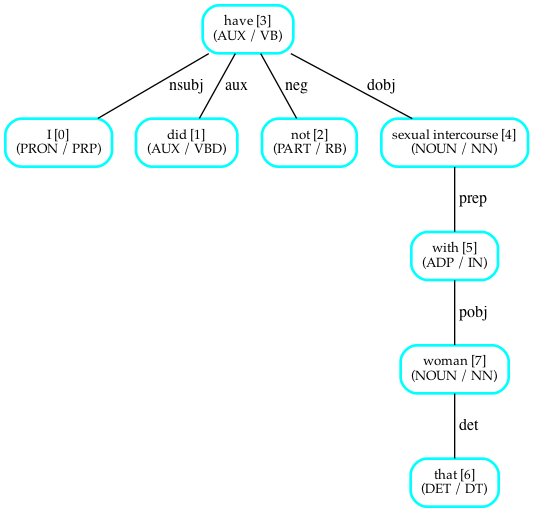

In [176]:
tree_vis(doc)

In [205]:
[*doc.sents][0]

I did not have sexual intercourse with that woman

In [207]:
hierplane([*doc.sents][0])

In [171]:
show_tabs(doc)

token               lemma               POS    Tag    DEP    shape      is_alpha    is_stop
------------------  ------------------  -----  -----  -----  ---------  ----------  ---------
I                   -PRON-              PRON   PRP    nsubj  X          True        True
did                 do                  AUX    VBD    aux    xxx        True        True
not                 not                 PART   RB     neg    xxx        True        True
have                have                AUX    VB     ROOT   xxxx       True        True
sexual intercourse  sexual intercourse  NOUN   NN     dobj   xxxx xxxx  False       False
with                with                ADP    IN     prep   xxxx       True        True
that                that                DET    DT     det    xxxx       True        True
woman               woman               NOUN   NN     pobj   xxxx       True        False


'Printed Table above'

In [ ]:
def pattern_from_shortest_dep_path():
    5
    
#def SDP(doc:Doc, a:Union[Span, Token], b: Union[Span, Token])->List[Union[Span,Token]]:

In [92]:
"""
NegEx Patterns
psuedo_negations - phrases that are false triggers, ambiguous negations, or double negatives
preceding_negations - negation phrases that precede an entity
following_negations - negation phrases that follow an entity
termination - phrases that cut a sentence in parts, for purposes of negation detection (.e.g., "but")
"""
#negex.get_patterns()

{'pseudo_patterns': [no further,
  not able to be,
  not certain if,
  not certain whether,
  not necessarily,
  without any further,
  without difficulty,
  without further,
  might not,
  not only,
  no increase,
  no significant change,
  no change,
  no definite change,
  not extend,
  not cause,
  not certain if,
  not certain whether,
  gram negative,
  not rule out,
  not ruled out,
  not been ruled out,
  not drain,
  no suspicious change,
  no interval change,
  no significant interval change],
 'preceding_patterns': [absence of,
  declined,
  denied,
  denies,
  denying,
  no sign of,
  no signs of,
  not,
  not demonstrate,
  symptoms atypical,
  doubt,
  negative for,
  no,
  versus,
  without,
  doesn't,
  doesnt,
  don't,
  dont,
  didn't,
  didnt,
  wasn't,
  wasnt,
  weren't,
  werent,
  isn't,
  isnt,
  aren't,
  arent,
  cannot,
  can't,
  cant,
  couldn't,
  couldnt,
  never,
  patient was not,
  without indication of,
  without sign of,
  without signs of,
  without

In [13]:
from operator import eq, ge, le

In [ ]:
PARAMS = {
    
    LEN_TRESH: 15,
    SUBTREE_LEN_TRESH: 6,
    
}

In [ ]:
texts = [
    
]

In [16]:
[len(sent) > LEN_TRESH for sent in doc.sents]

[9]

In [21]:
from spacy.matcher import Matcher
nlp = spacy.load("en_core_web_sm")
doc = nlp("This is a really nice, green apple. One apple a day ...!")
matcher = Matcher(nlp.vocab)

pattern = [{'ORTH': 'is'}]
for i in range(0,5): #aribtrary number of wild cards in between
    pattern.append({"OP": "?"}) 
pattern.append({"ORTH": "apple"})

matcher.add('test', None, pattern)
spans = [doc[start:end] for match_id, start, end in matcher(doc)]
for span in spans:
    print(spans)


[is a really nice, green apple]
